In [296]:
import numpy as np # type: ignore
import os
import pandas as pd  # type: ignore
import matplotlib.pyplot as plt  # type: ignore
import scipy.stats as sis  # type: ignore
import warnings
import seaborn as sns
import scipy.signal as signal
warnings.filterwarnings('ignore')
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report,confusion_matrix

In [297]:
def cargar_dataframe_paciente(ruta):
    df = pd.DataFrame(pd.read_csv(ruta,sep='\t',low_memory=False))
    return df
def clasificar_movimientos(df1):
    n0=df1[df1['class']==0]
    n1=df1[df1['class']==1]
    n2=df1[df1['class']==2]
    n3=df1[df1['class']==3]
    n4=df1[df1['class']==4]
    n5=df1[df1['class']==5]
    n6=df1[df1['class']==6]
    n7=df1[df1['class']==7]
    if len(n7) == 0:
        return n0,n1,n2,n3,n4,n5,n6
    else:
        return n0,n1,n2,n3,n4,n5,n6,n7
def TKEO(signal):
    tkeo = np.zeros_like(signal)    
    for n in range(1, len(signal) - 1):
        tkeo[n] = signal[n]**2 - signal[n-1] * signal[n+1]
    tkeo[0] = 0
    tkeo[-1] = 0    
    return tkeo
def calculate_rms(signal):
    """Calcula el valor RMS (Root Mean Square) de la señal."""
    return np.sqrt(np.mean(np.square(signal)))

def calculate_variance(signal):
    """Calcula la varianza de la señal."""
    return np.var(signal)

def calculate_mav(signal):
    """Calcula el Mean Absolute Value (MAV) de la señal."""
    return np.mean(np.abs(signal))

def calculate_mav_slope(signal):
    """Calcula el Mean Absolute Value Slope (MAVS) de la señal."""
    return np.mean(np.abs(np.diff(signal)))

def calculate_ssc(signal, threshold=0):
    """Calcula el número de Slope Sign Changes (SSC) en la señal."""
    ssc = np.sum(np.diff(np.sign(np.diff(signal))) != 0)
    return ssc

def calculate_wl(signal):
    """Calcula la longitud de la forma de onda (Waveform Length, WL) de la señal."""
    return np.sum(np.abs(np.diff(signal)))

def calculate_zero_crossings(signal):
    """Calcula el número de Zero Crossings (ZC) en la señal."""
    zero_crossings = ((signal[:-1] * signal[1:]) < 0).sum()
    return zero_crossings
def calcular_metricas(dict_senal):
    metricas = {}
    for i in range(len(dict_senal)):
        senal = np.array(dict_senal[f'Clase {i}'])
        rms = calculate_rms(senal)
        var = calculate_variance(senal)
        mav = calculate_mav(senal)
        mav_slope = calculate_mav_slope(senal)
        ssc = calculate_ssc(senal)
        wl = calculate_wl(senal)
        zc = calculate_zero_crossings(senal)
        metricas[f'Clase {i}']=[rms,var,mav,mav_slope,ssc,wl,zc]
    return metricas
def crear_dataframe(metricas):
    lista_metricas = ['RMS','Varianza','Mean Aboslute Value','Mean Absolute Value Slope','Slope Sign Changes','Wave Form Lenght','Zero Crossing']
    df_metricas= pd.DataFrame.from_dict(metricas, orient='index', columns=lista_metricas)
    return df_metricas 


In [298]:
carpeta = input('Ingrese el paciente: ')
# carpeta = '13'
ruta = f'EMG_data_for_gestures-master\\{carpeta}'
series = os.listdir(ruta)
paciente = cargar_dataframe_paciente(ruta+'\\'+series[0])
database = clasificar_movimientos(paciente)

In [299]:
def corte_datos(dataframe):
    n=dataframe.drop(columns=['time','class'])
    return n
def conversion_uni(dataframe):
    dataframe['Average'] = dataframe.mean(axis=1)
    # Crear un nuevo DataFrame con solo la columna de promedios
    df_avg = dataframe[['Average']]
    # Mostrar el nuevo DataFrame
    return df_avg
def crear_clases(dataframe):
    Clases = {}
    try:
        for i in range(0,8):
            df=corte_datos(dataframe[i])
            df=conversion_uni(df)
            Clases[f'Clase {i}']= list(df['Average'])
    except IndexError:
        for i in range(0,7):
            df=corte_datos(dataframe[i])
            df=conversion_uni(df)
            Clases[f'Clase {i}']= list(df['Average'])
    return Clases
def crear_tiempo(dataframe):
    t = []
    for i in range(len(dataframe)):
        tc = len(dataframe[f'Clase {i}'])
        tc = np.arange(0,tc,1)
        t.append(tc)
    return t
def filtrado(dict_clases):
    clases_filtrado={}
    for i in range(len(dict_clases)):
        Fs = 1/0.001 # frecuencia de nyquist
        nyquist = Fs/2
        low_fc = 120/nyquist #frecuencia de corte normalizada respecto nyquist
        low_senal = signal.firwin(100+1,low_fc,pass_zero = 'lowpass',window='hamming')
        salida1 = signal.filtfilt(b=low_senal,a=1,x=dict_clases[f'Clase {i}'])
        high_fc = 10/nyquist
        high_senal = signal.firwin(100+1,high_fc,pass_zero = 'highpass',window='hamming')
        salida2 = signal.filtfilt(b=low_senal,a=1,x=salida1)
        band_fc = [50/nyquist,60/nyquist]
        band_stop = signal.firwin(100+1,band_fc,pass_zero = 'bandstop',window='hamming')
        salida3 = signal.filtfilt(b=high_senal,a=1,x=salida2)
        clases_filtrado[f'Clase {i}']=list(salida3)
    return clases_filtrado


# Importante, aquí estan todas las clases

In [300]:
clases_global=crear_clases(database)


In [301]:
t = crear_tiempo(clases_global)

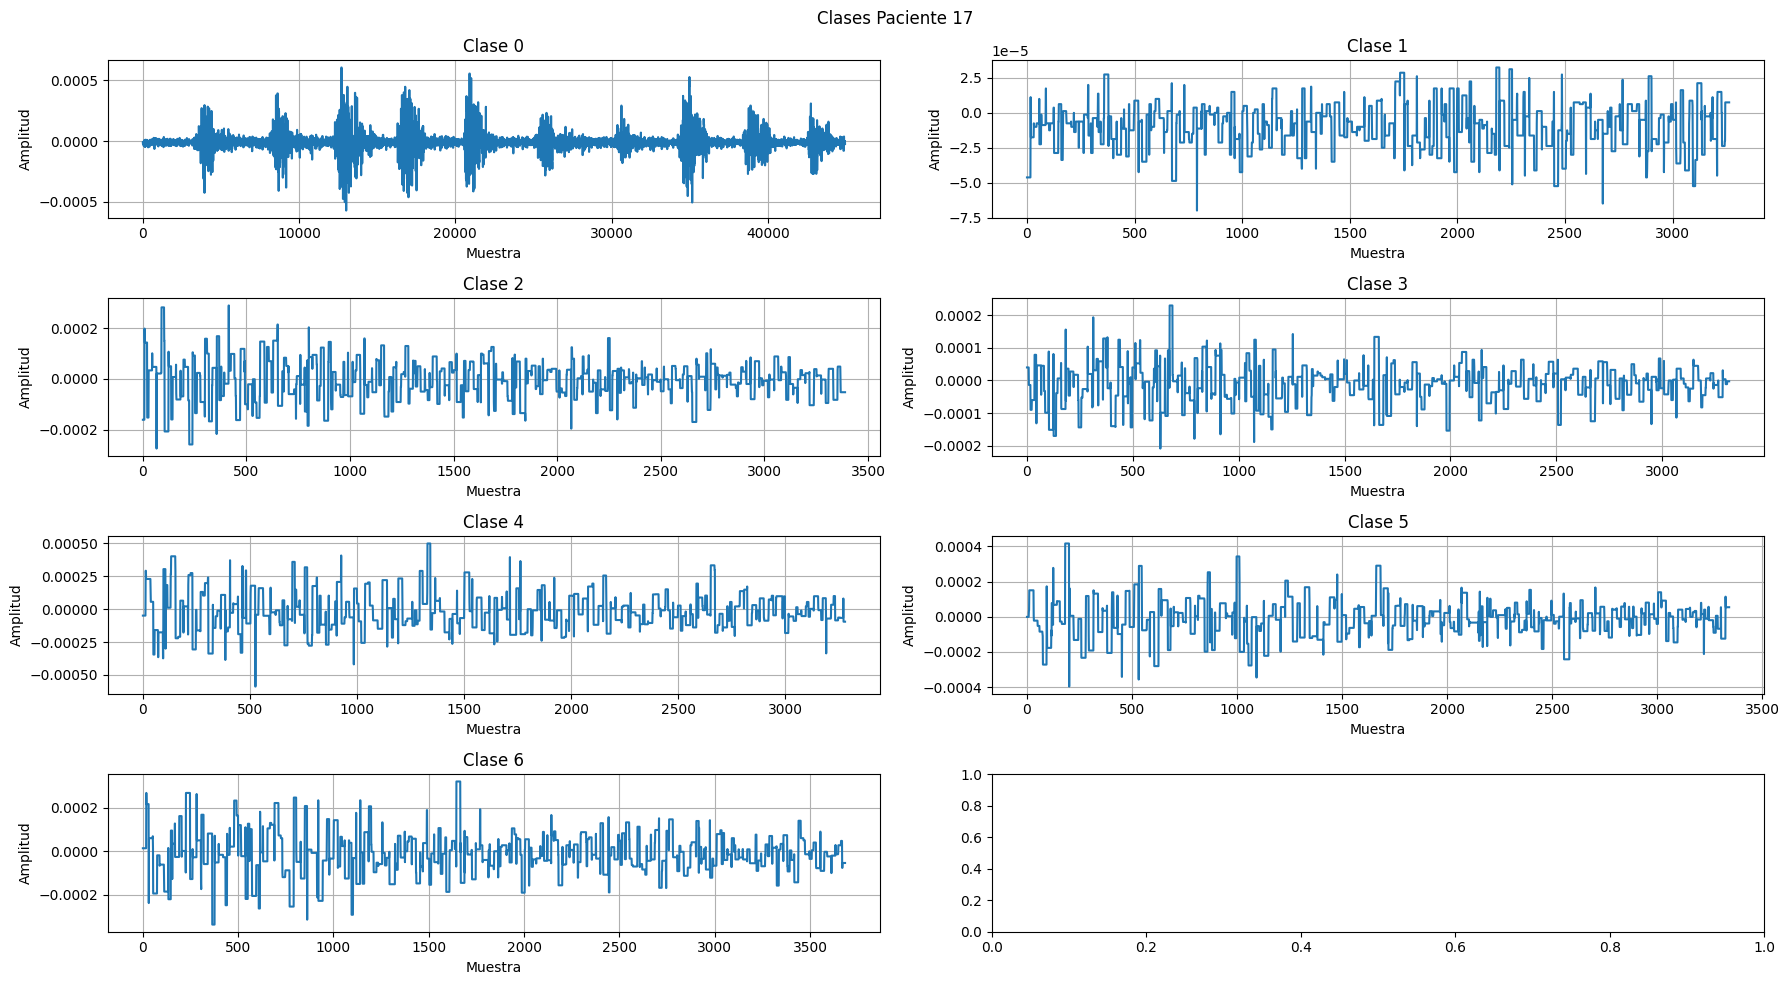

In [302]:
fig,axs=plt.subplots(4,2,figsize=(18,10))
axs=axs.flatten()
for i in range(len(clases_global)):
    axs[i].plot(t[i],clases_global[f'Clase {i}'])
    axs[i].set_title(f'Clase {i}')
    axs[i].grid(True)
    axs[i].set_xlabel('Muestra')
    axs[i].set_ylabel('Amplitud')
plt.suptitle(f'Clases Paciente {carpeta}')
plt.tight_layout()
plt.show()

In [303]:
clases_filtrada = filtrado(clases_global)

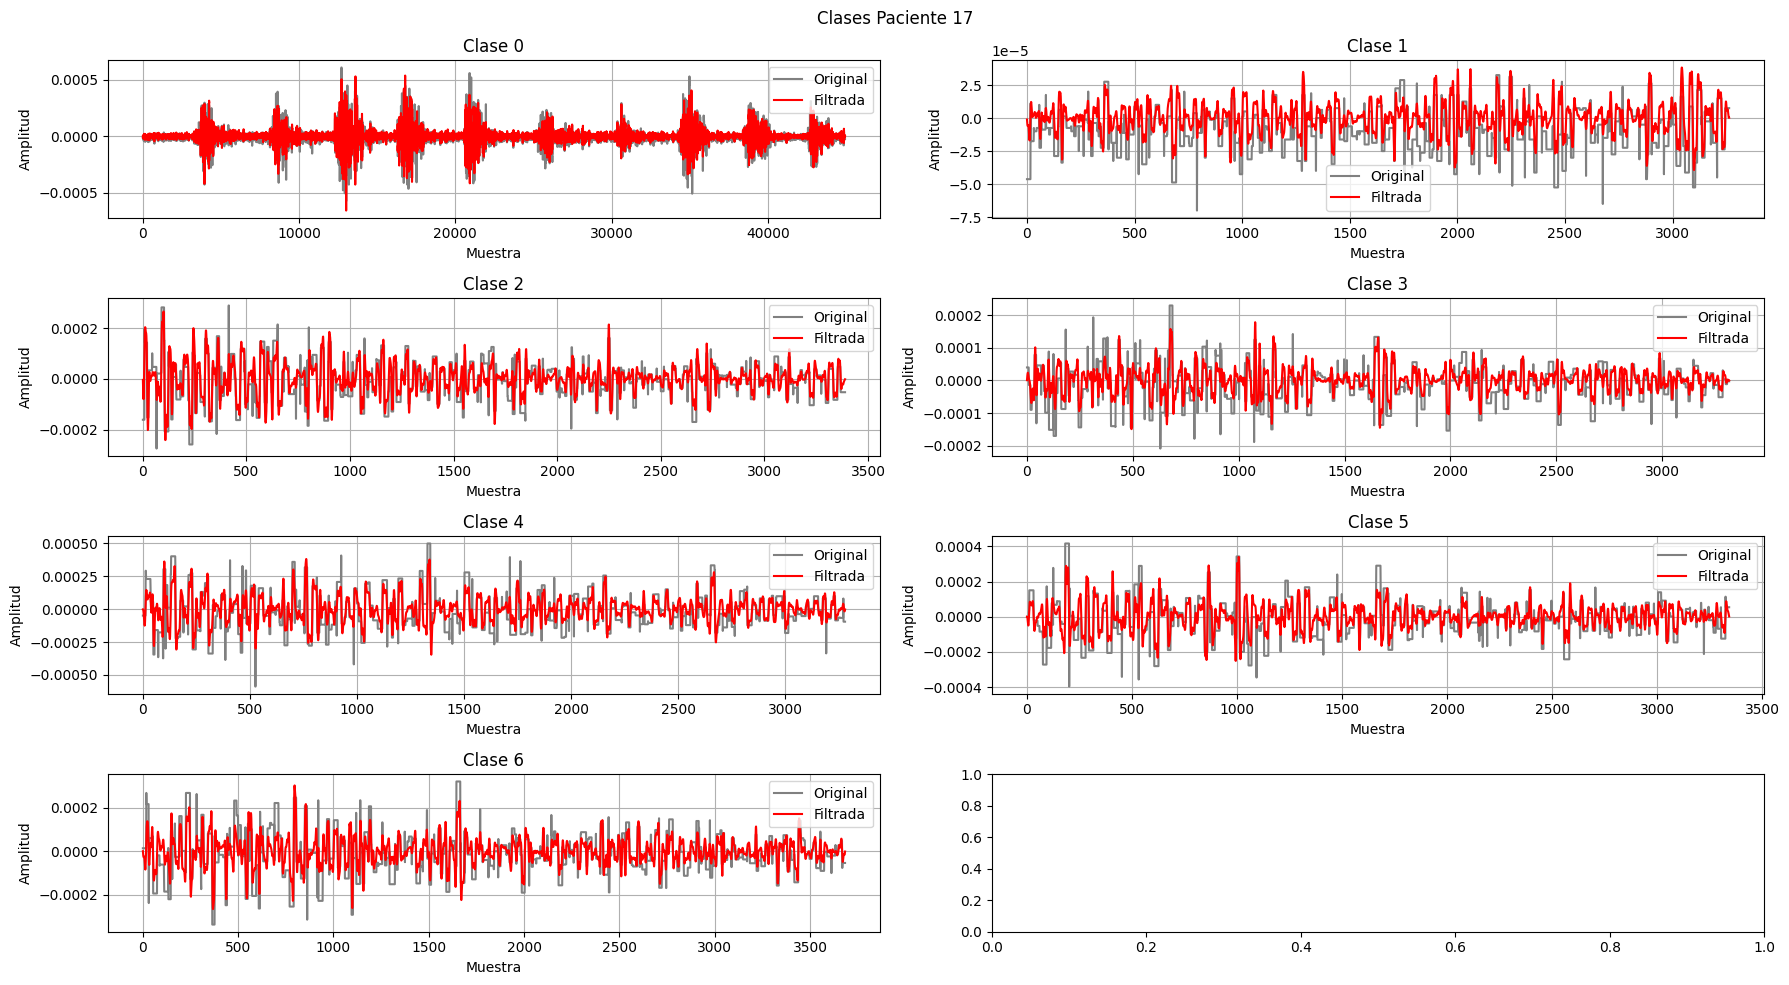

In [304]:
fig,axs=plt.subplots(4,2,figsize=(18,10))
axs=axs.flatten()
for i in range(len(clases_global)):
    axs[i].plot(t[i],clases_global[f'Clase {i}'],color='grey',label='Original')
    axs[i].plot(t[i],clases_filtrada[f'Clase {i}'],color='red',label='Filtrada')
    axs[i].set_title(f'Clase {i}')
    axs[i].grid(True)
    axs[i].set_xlabel('Muestra')
    axs[i].set_ylabel('Amplitud')
    axs[i].legend()
plt.suptitle(f'Clases Paciente {carpeta}')
plt.tight_layout()
plt.show()

TKEO

In [305]:
clases_tkeo = {}
for i in range(len(clases_global)):
    tk = TKEO(clases_global[f'Clase {i}'])
    clases_tkeo[f'Clase {i}']=list(tk)

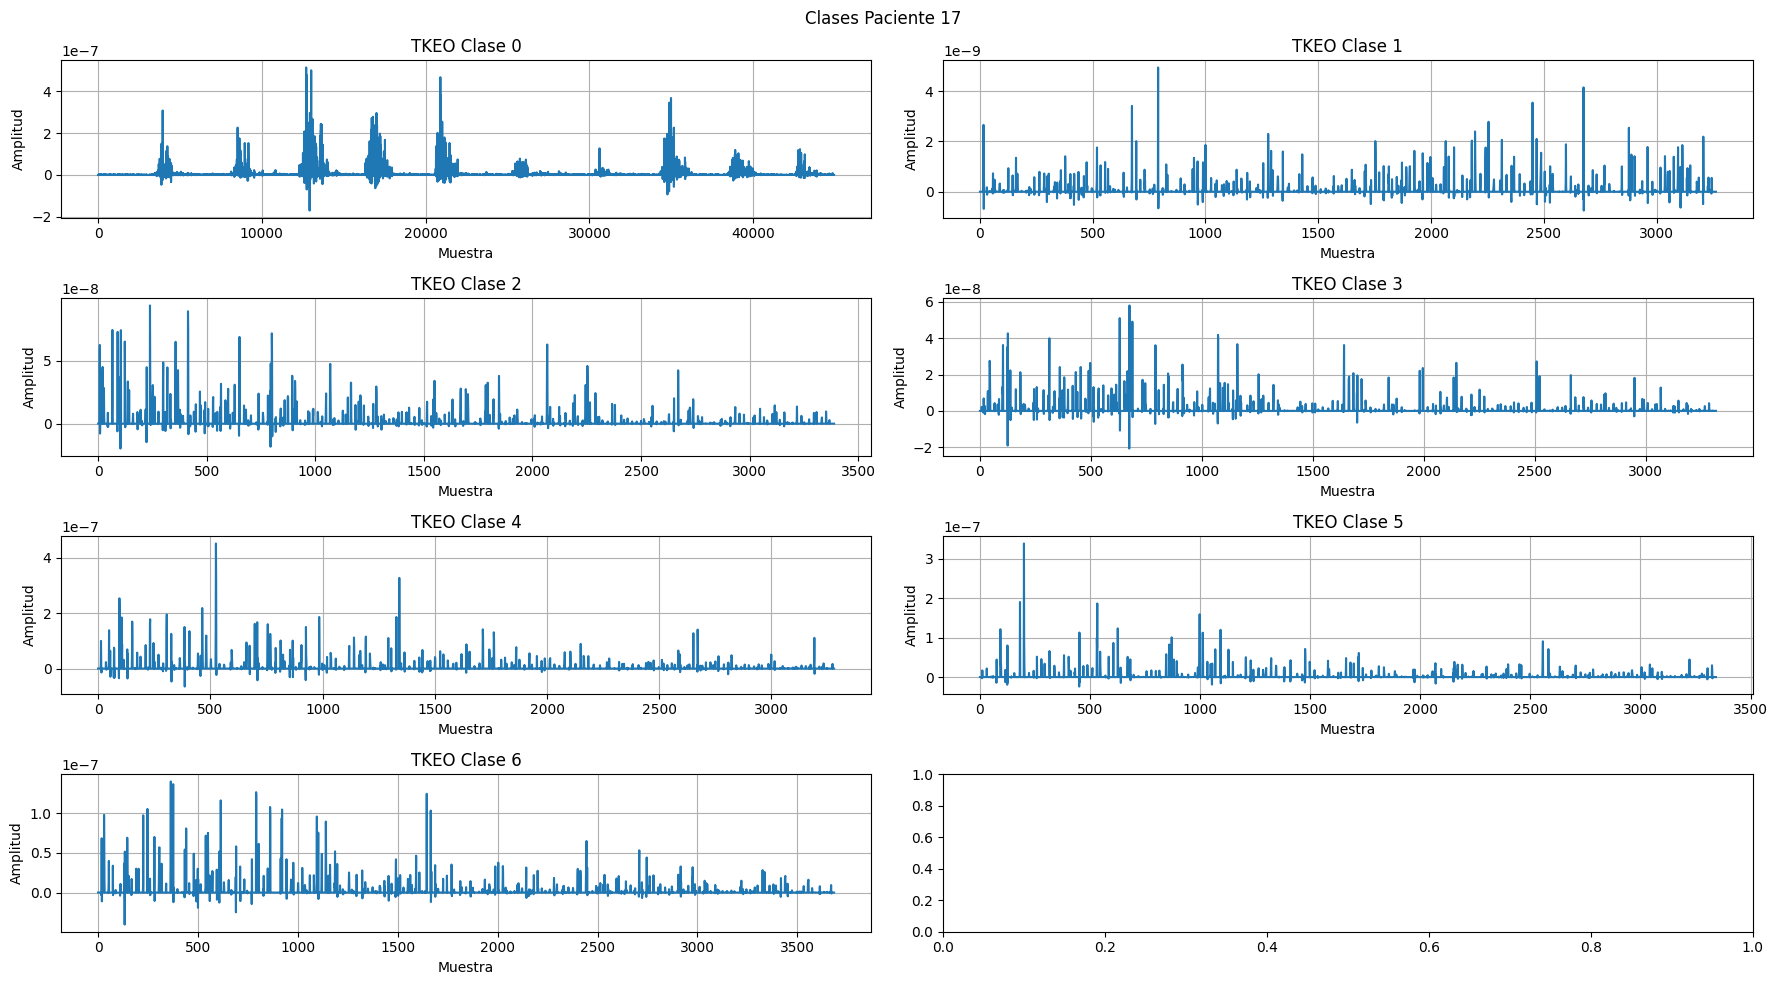

In [306]:
fig,axs=plt.subplots(4,2,figsize=(18,10))
axs=axs.flatten()
for i in range(len(clases_tkeo)):
    axs[i].plot(t[i],clases_tkeo[f'Clase {i}'])
    axs[i].set_title(f'TKEO Clase {i}')
    axs[i].grid(True)
    axs[i].set_xlabel('Muestra')
    axs[i].set_ylabel('Amplitud')
plt.suptitle(f'Clases Paciente {carpeta}')
plt.tight_layout()
plt.show()

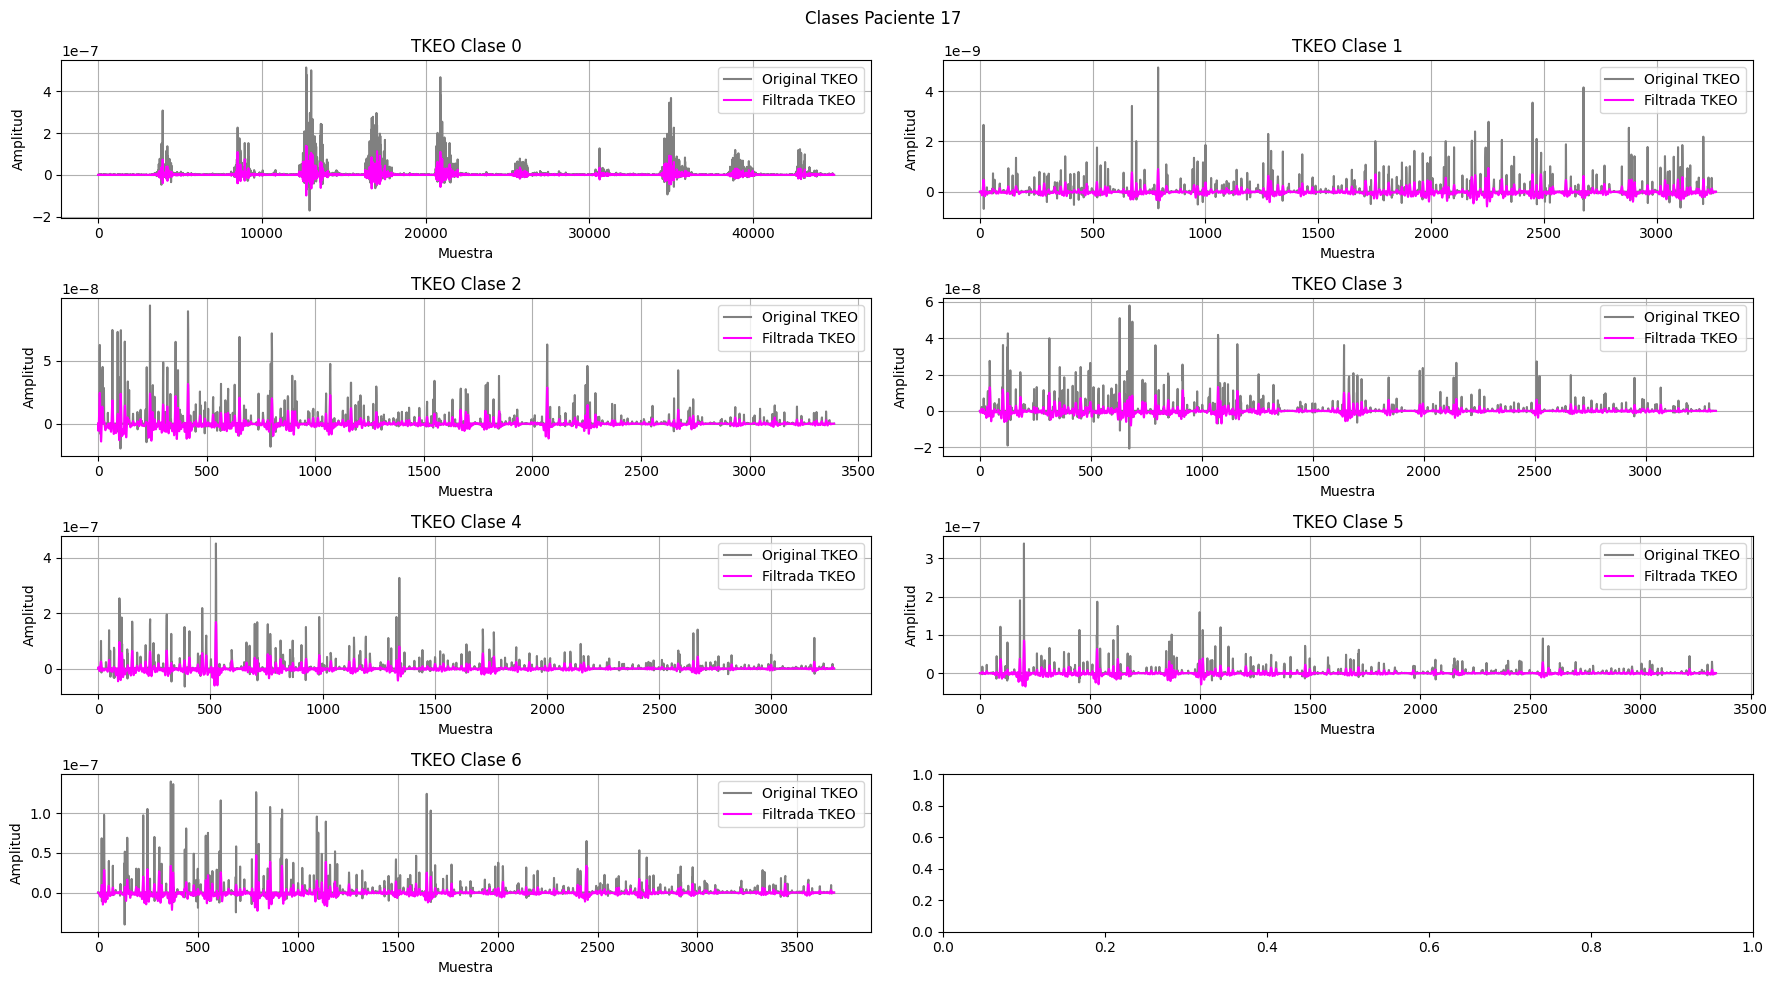

In [307]:
clases_tkeo_filtrado = filtrado(clases_tkeo)
fig,axs=plt.subplots(4,2,figsize=(18,10))
axs=axs.flatten()
for i in range(len(clases_tkeo)):
    axs[i].plot(t[i],clases_tkeo[f'Clase {i}'],color='grey',label='Original TKEO')
    axs[i].plot(t[i],clases_tkeo_filtrado[f'Clase {i}'],color='magenta',label='Filtrada TKEO')
    axs[i].set_title(f'TKEO Clase {i}')
    axs[i].grid(True)
    axs[i].set_xlabel('Muestra')
    axs[i].set_ylabel('Amplitud')
    axs[i].legend()
plt.suptitle(f'Clases Paciente {carpeta}')
plt.tight_layout()
plt.show()

### Recordar
- Indice [0] = RMS
- Indice [1] = Varianza
- Indice [2] = Mean Absolute Value
- Indice [3] = Mean Absolute Value Slope
- Indice [4] = Slope Sign Changes
- Indice [5] = Wave Form Lenght
- Indice [7] = Zero Crossing


In [308]:
metricas_original = calcular_metricas(clases_global)
metricas_filtrado = calcular_metricas(clases_filtrada)
metricas_TKEO = calcular_metricas(clases_tkeo)
metricas_TKEO_filt = calcular_metricas(clases_tkeo_filtrado)


In [309]:
df_met_org = crear_dataframe(metricas_original)
df_met_filt = crear_dataframe(metricas_filtrado)
df_met_tkeo = crear_dataframe(metricas_TKEO)
df_met_tkeo_filt = crear_dataframe(metricas_TKEO_filt)

In [310]:
print("Métricas Clases Originales")
display(df_met_org)
print("Métricas Clases Filtradas")
display(df_met_filt)
print("Métricas Clases TKEO")
display(df_met_tkeo)
print("Métricas Clases TKEO Filtradas")
display(df_met_tkeo_filt)

Métricas Clases Originales


,RMS,Varianza,Mean Aboslute Value,Mean Absolute Value Slope,Slope Sign Changes,Wave Form Lenght,Zero Crossing
Clase 0,0.000081,6.525992e-09,0.000046,0.000008,7892,0.337091,2434
Clase 1,0.000019,2.774116e-10,0.000015,0.000002,545,0.007496,160
Clase 2,0.000080,6.327977e-09,0.000061,0.000011,633,0.035824,208
Clase 3,0.000061,3.646121e-09,0.000046,0.000008,561,0.027503,201
Clase 4,0.000146,2.100106e-08,0.000114,0.000018,549,0.059156,168
Clase 5,0.000111,1.215014e-08,0.000082,0.000013,555,0.043340,181
Clase 6,0.000101,1.004082e-08,0.000076,0.000012,633,0.044105,218


Métricas Clases Filtradas


,RMS,Varianza,Mean Aboslute Value,Mean Absolute Value Slope,Slope Sign Changes,Wave Form Lenght,Zero Crossing
Clase 0,0.000055,3.072853e-09,0.000030,0.000007,7299,0.313997,3186
Clase 1,0.000012,1.465054e-10,0.000009,0.000002,549,0.006743,221
Clase 2,0.000062,3.826355e-09,0.000045,0.000010,539,0.035123,254
Clase 3,0.000039,1.542815e-09,0.000029,0.000007,554,0.022014,237
Clase 4,0.000099,9.747867e-09,0.000075,0.000017,549,0.055054,232
Clase 5,0.000074,5.518158e-09,0.000055,0.000012,558,0.039403,225
Clase 6,0.000065,4.240469e-09,0.000048,0.000011,577,0.041430,263


Métricas Clases TKEO


,RMS,Varianza,Mean Aboslute Value,Mean Absolute Value Slope,Slope Sign Changes,Wave Form Lenght,Zero Crossing
Clase 0,1.275600e-08,1.609028e-16,1.553041e-09,2.224558e-09,11534,9.998277e-05,2479
Clase 1,3.021162e-10,8.762979e-20,7.450597e-11,1.167685e-10,835,3.810156e-07,196
Clase 2,6.989162e-09,4.670487e-17,1.643281e-09,2.228411e-09,897,7.552084e-06,191
Clase 3,3.969691e-09,1.518214e-17,9.028476e-10,1.367221e-09,830,4.535072e-06,186
Clase 4,2.267382e-08,4.949085e-16,5.010015e-09,6.905956e-09,807,2.264463e-05,164
Clase 5,1.254590e-08,1.525816e-16,2.464533e-09,3.593724e-09,796,1.201382e-05,177
Clase 6,1.020636e-08,1.003930e-16,2.192790e-09,3.253220e-09,914,1.198486e-05,181


Métricas Clases TKEO Filtradas


,RMS,Varianza,Mean Aboslute Value,Mean Absolute Value Slope,Slope Sign Changes,Wave Form Lenght,Zero Crossing
Clase 0,6.563481e-09,4.307822e-17,1.919998e-09,8.543960e-10,8400,3.840083e-05,5732
Clase 1,1.426145e-10,2.033628e-20,8.913191e-11,4.021554e-11,613,1.312233e-07,420
Clase 2,3.795639e-09,1.440377e-17,2.048470e-09,9.265461e-10,644,3.140065e-06,441
Clase 3,1.923605e-09,3.699939e-18,1.075078e-09,4.820774e-10,618,1.599051e-06,414
Clase 4,1.275776e-08,1.627453e-16,6.658078e-09,3.048161e-09,612,9.994921e-06,443
Clase 5,6.578233e-09,4.326999e-17,3.295440e-09,1.480348e-09,632,4.948802e-06,445
Clase 6,5.289243e-09,2.797374e-17,2.864838e-09,1.268280e-09,689,4.672342e-06,452


Analisis Gráfico

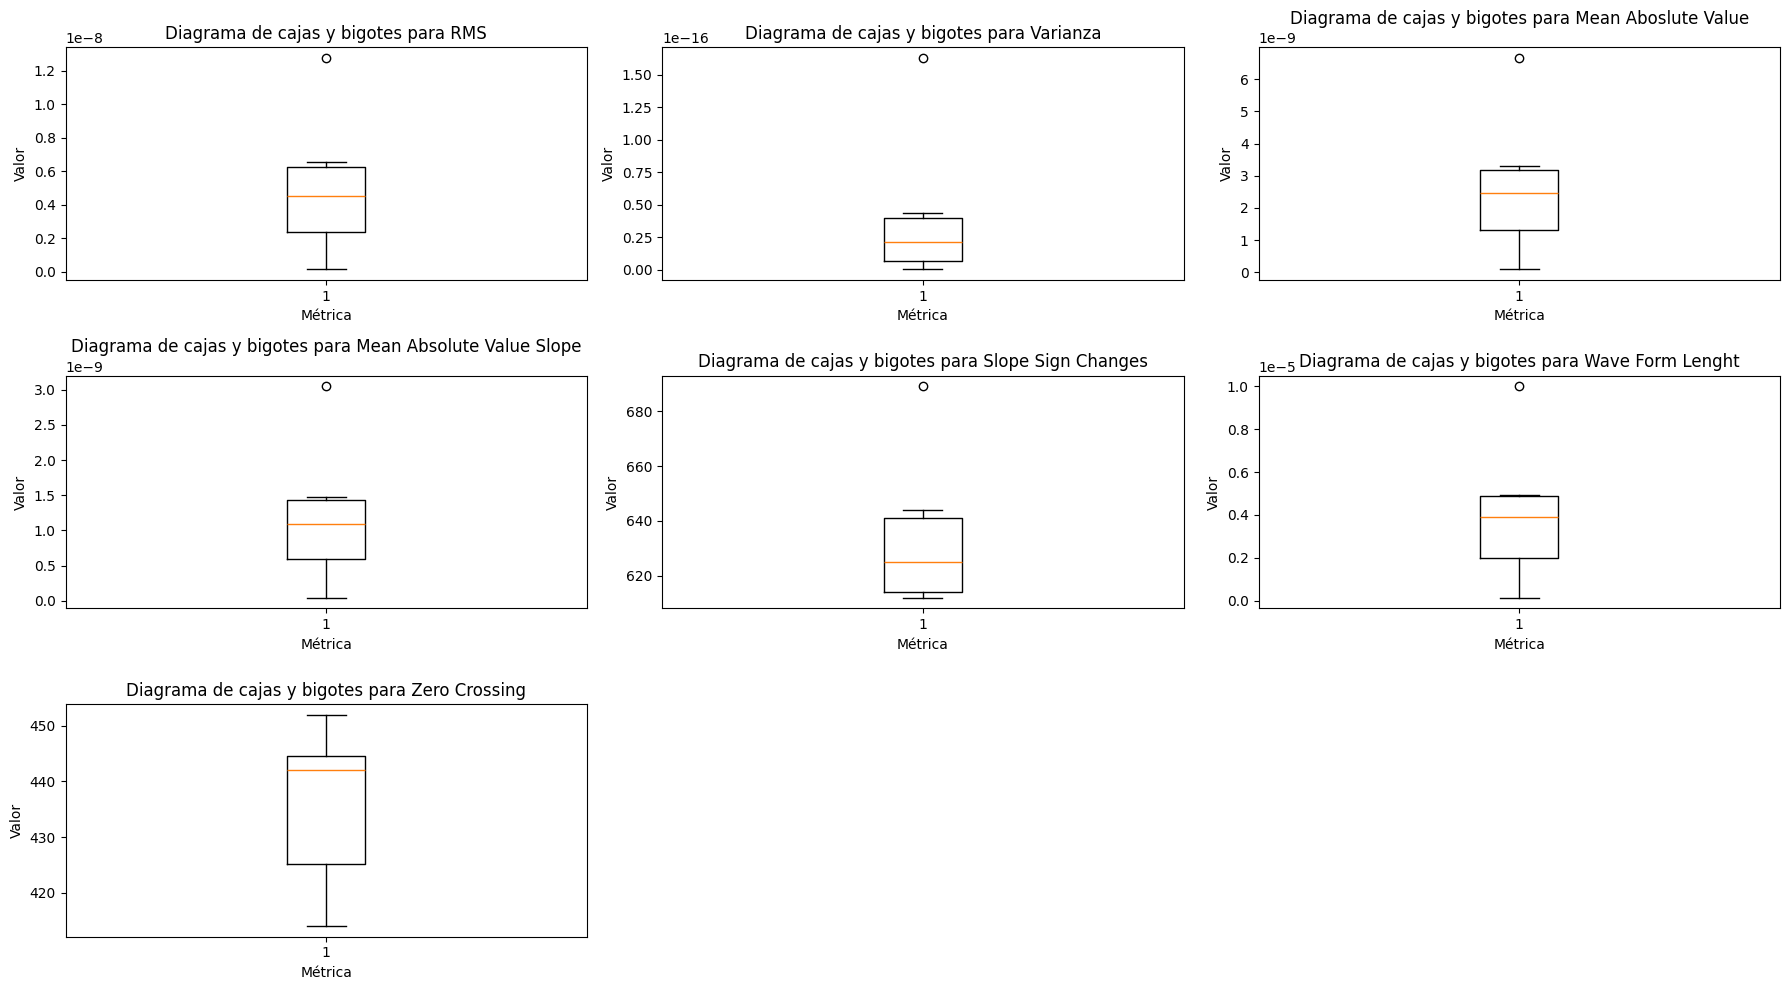

,RMS,Varianza,Mean Aboslute Value,Mean Absolute Value Slope,Slope Sign Changes,Wave Form Lenght,Zero Crossing
Clase 1,1.426145e-10,2.033628e-20,8.913191e-11,4.021554e-11,613,1.312233e-07,420
Clase 2,3.795639e-09,1.440377e-17,2.048470e-09,9.265461e-10,644,3.140065e-06,441
Clase 3,1.923605e-09,3.699939e-18,1.075078e-09,4.820774e-10,618,1.599051e-06,414
Clase 4,1.275776e-08,1.627453e-16,6.658078e-09,3.048161e-09,612,9.994921e-06,443
Clase 5,6.578233e-09,4.326999e-17,3.295440e-09,1.480348e-09,632,4.948802e-06,445
Clase 6,5.289243e-09,2.797374e-17,2.864838e-09,1.268280e-09,689,4.672342e-06,452


In [311]:
df_bin = df_met_tkeo_filt.drop(index='Clase 0')
labels_n = df_bin.columns.tolist()

num_cols = 3
num_rows = (len(labels_n) + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 10))

for ax, label in zip(axes.flatten(), labels_n):
    ax.boxplot(df_bin[label])
    ax.set_title(f'Diagrama de cajas y bigotes para {label}')
    ax.set_xlabel('Métrica')
    ax.set_ylabel('Valor')

for ax in axes.flatten()[len(labels_n):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()
display(df_bin)

Implementación de Modelo Scikit

In [312]:
df_bin['Clase'] = [1,2,3,4,5,6]
df_bin['RMS'] = (df_bin['Clase'].isin([1, 2])).astype(int)
display(df_bin)

,RMS,Varianza,Mean Aboslute Value,Mean Absolute Value Slope,Slope Sign Changes,Wave Form Lenght,Zero Crossing,Clase
Clase 1,1,2.033628e-20,8.913191e-11,4.021554e-11,613,1.312233e-07,420,1
Clase 2,1,1.440377e-17,2.048470e-09,9.265461e-10,644,3.140065e-06,441,2
Clase 3,0,3.699939e-18,1.075078e-09,4.820774e-10,618,1.599051e-06,414,3
Clase 4,0,1.627453e-16,6.658078e-09,3.048161e-09,612,9.994921e-06,443,4
Clase 5,0,4.326999e-17,3.295440e-09,1.480348e-09,632,4.948802e-06,445,5
Clase 6,0,2.797374e-17,2.864838e-09,1.268280e-09,689,4.672342e-06,452,6


In [313]:
df_bin.describe()

,RMS,Varianza,Mean Aboslute Value,Mean Absolute Value Slope,Slope Sign Changes,Wave Form Lenght,Zero Crossing,Clase
count,6.000000,6.000000e+00,6.000000e+00,6.000000e+00,6.000000,6.000000e+00,6.000000,6.000000
mean,0.333333,4.201884e-17,2.671839e-09,1.207605e-09,634.666667,4.081067e-06,435.833333,3.500000
std,0.516398,6.126746e-17,2.277052e-09,1.042487e-09,29.350752,3.427051e-06,15.171245,1.870829
min,0.000000,2.033628e-20,8.913191e-11,4.021554e-11,612.000000,1.312233e-07,414.000000,1.000000
25%,0.000000,6.375897e-18,1.318426e-09,5.931946e-10,614.250000,1.984304e-06,425.250000,2.250000
50%,0.000000,2.118876e-17,2.456654e-09,1.097413e-09,625.000000,3.906203e-06,442.000000,3.500000
75%,0.750000,3.944593e-17,3.187789e-09,1.427331e-09,641.000000,4.879687e-06,444.500000,4.750000
max,1.000000,1.627453e-16,6.658078e-09,3.048161e-09,689.000000,9.994921e-06,452.000000,6.000000


In [314]:
target_column = ['RMS']
predictors = list(set(list(df_bin.columns))-set(target_column))
print(predictors)
df_bin[predictors] = df_bin[predictors]/df_bin[predictors].max()
df_bin.describe()

['Wave Form Lenght', 'Zero Crossing', 'Slope Sign Changes', 'Clase', 'Mean Absolute Value Slope', 'Mean Aboslute Value', 'Varianza']


,RMS,Varianza,Mean Aboslute Value,Mean Absolute Value Slope,Slope Sign Changes,Wave Form Lenght,Zero Crossing,Clase
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
mean,0.333333,0.258188,0.401293,0.396175,0.921142,0.408314,0.964233,0.583333
std,0.516398,0.376462,0.341998,0.342005,0.042599,0.342879,0.033565,0.311805
min,0.000000,0.000125,0.013387,0.013193,0.888244,0.013129,0.915929,0.166667
25%,0.000000,0.039177,0.198019,0.194607,0.891509,0.198531,0.940819,0.375000
50%,0.000000,0.130196,0.368973,0.360025,0.907112,0.390819,0.977876,0.583333
75%,0.750000,0.242378,0.478785,0.468260,0.930334,0.488217,0.983407,0.791667
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [315]:
#%% Step 4 - Creating the Training and Test Datasets
X = df_bin[predictors].values
y = df_bin[target_column].values

#the same seed is used to partition to obtain the same results
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)
y_test = np.squeeze(y_test)
y_train = np.squeeze(y_train)
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(4, 7)
(4,)
(2, 7)
(2,)


In [316]:
#Three hidden layer each layer with eigth neurons
mlp = MLPClassifier(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=1000)
print(mlp)

MLPClassifier(hidden_layer_sizes=(8, 8, 8), max_iter=1000)


In [317]:
mlp.fit(X_train,y_train)

predict_train = mlp.predict(X_train)
predict_test = mlp.predict(X_test)

In [318]:
#%% Results
print(confusion_matrix(y_train,predict_train))

[[3 0]
 [0 1]]


In [319]:
target_names = ['Estático', 'Movimiento']
print(classification_report(y_train,predict_train,target_names=target_names))

              precision    recall  f1-score   support

    Estático       1.00      1.00      1.00         3
  Movimiento       1.00      1.00      1.00         1

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



In [320]:
print(confusion_matrix(y_test,predict_test))

[[1 0]
 [1 0]]


In [321]:
print(classification_report(y_test,predict_test,target_names=target_names))

              precision    recall  f1-score   support

    Estático       0.50      1.00      0.67         1
  Movimiento       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



In [322]:
from itertools import product
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig=plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[3 0]
 [0 1]]


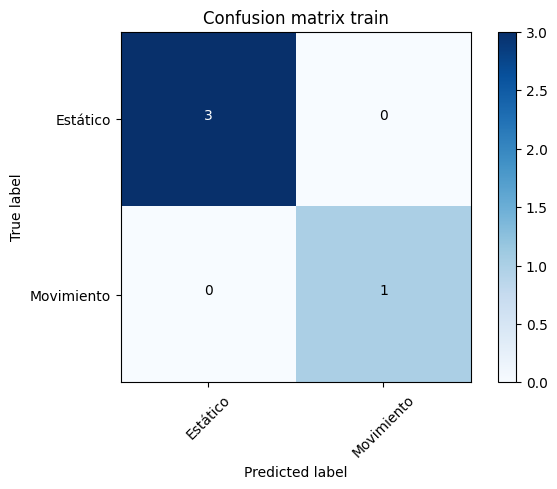

In [323]:
mc_train = confusion_matrix(y_train,predict_train)
plot_confusion_matrix(mc_train, classes=target_names,
                      title='Confusion matrix train')

Confusion matrix, without normalization
[[1 0]
 [1 0]]


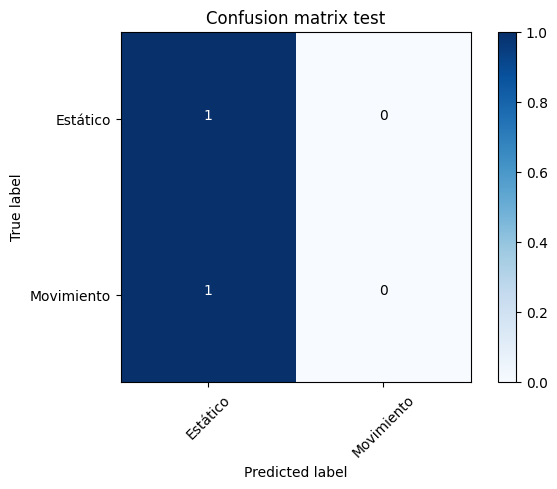

In [324]:
mc_test = confusion_matrix(y_test,predict_test)
plot_confusion_matrix(mc_test, classes=target_names,
                      title='Confusion matrix test')

# Punto F (Investigación e implementación de mas Modelos):

## Bosques aleatorios y árboles de decisión:
- Los árboles de decisión y los bosques aleatorios son modelos de aprendizaje automático únicos para la clasificación de señales EMG. Los árboles de decisión ofrecen una interpretación fácilmente comprensible de cómo se toman las decisiones, lo que puede ayudar a identificar características importantes en las señales EMG. Además, los bosques aleatorios pueden mejorar la precisión de la clasificación y reducir el sobreajuste al combinar varios árboles de decisión. Esto los hace excelentes para proporcionar clasificaciones precisas y manejar la variabilidad en las señales EMG.


## Máquinas de soporte vectorial:
- Estas máquinas buscan el hiperplano ideal que separará las diferentes clases en el espacio de características de manera más efectiva. Las SVM son efectivas para clasificar gestos de señales EMG porque pueden manejar espacios de alta dimensión y conjuntos de datos pequeños pero bien definidos. Además, son adecuadas para una amplia gama de problemas de clasificación debido a su capacidad para modelar relaciones no lineales entre características.

### Proceso:
1. Preprocesamiento de Datos
2. Entrenamiento del Modelo
3. Evaluación del Modelo
4. Ajuste y Optimización
5. Despliegue del Modelo

# Punto G (Implementación en sistemas embebidos)
1. Selección del Microcontrolador
    Escogimos el ESP-32 Node MCU, ya que proporciona conectividad Wi-Fi y Bluetooth integrada, además de una capacidad de procesamiento significativamente superior a la de otros microcontroladores. Esta característica resulta ventajosa si se requiere la transmisión inalámbrica de datos EMG o la ejecución de tareas de procesamiento intensivo en el propio dispositivo.

2. Optimización del Modelo
    Reducir el tamaño del modelo, simplificar la arquitectura y aplicar cuantización de pesos son esenciales para optimizar la adquisición y clasificación de señales EMG con el microcontrolador ESP-32. La integración con herramientas especializadas como TensorFlow Lite Micro y la evaluación del rendimiento son esenciales. Además, las pruebas de eficiencia aseguran que el modelo funcione eficientemente con recursos limitados del microcontrolador en tiempo real.

3. Integración del Modelo en el Microcontrolador

    Para integrar el modelo en el microcontrolador ESP-32, primero se debe convertir el modelo entrenado en un formato compatible, como TensorFlow Lite. Luego, utilizando las herramientas y funciones adecuadas, se debe incorporar el modelo en el código del microcontrolador. Después de configurar las entradas y salidas requeridas, se realizan pruebas detalladas para garantizar que funcionen correctamente y el código se optimiza para reducir el uso de recursos del microcontrolador durante la ejecución del modelo. Este procedimiento garantiza que el modelo funcione correctamente en el dispositivo y produzca resultados precisos al clasificar señales EMG.

4. Adquisición de Señales

    El rendimiento del modelo integrado en el microcontrolador ESP-32 se evalua mediante pruebas rigurosas para verificar su eficiencia y precisión en la clasificación de señales EMG. Para garantizar que el modelo pueda funcionar de manera eficiente con los recursos limitados del microcontrolador en tiempo real, se examinan métricas importantes como la precisión de la clasificación, el tiempo de respuesta y el consumo de recursos. Estas pruebas se utilizan para modificar el modelo y el código del microcontrolador para garantizar un rendimiento óptimo en la clasificación de gestos.

5. Clasificación de Señales
    
    Después de evaluar y optimizar el rendimiento del modelo en el microcontrolador ESP-32, se lleva a cabo su implementación en un entorno de producción. En esta etapa, el sistema se implementa para el uso previsto. Esto puede incluir la integración con otros componentes del sistema, la configuración de la interfaz de usuario y la realización de pruebas adicionales en condiciones reales. Para facilitar la gestión y mantenimiento posterior del sistema, se registran todos los pasos y resultados obtenidos durante el despliegue.

6. Validación en el Entorno de Despliegue

    El proceso de validación esto implica monitorear métricas importantes como la precisión de la clasificación, el tiempo de respuesta y el consumo de recursos para identificar problemas o áreas de mejora. Se pueden realizar ajustes y mejoras en el sistema, como la optimización del modelo o la actualización del firmware, para garantizar un rendimiento óptimo a lo largo del tiempo, basándose en estas métricas. Para mantener el proceso de seguimiento transparente y eficiente, todos los cambios realizados se registran y se comunican de manera efectiva a todas las partes interesadas.

7. Documentación y Despliegue

    Esto implica crear una documentación detallada que explique cada paso realizado, las configuraciones utilizadas, los resultados obtenidos y cualquier problema que surja durante el proceso. Además, se garantiza que esta documentación esté fácilmente accesible para todas las partes interesadas y se promueva una comunicación clara y efectiva sobre el despliegue del sistema. Esto garantiza un mantenimiento regular y eficiente del sistema a lo largo del tiempo.